## Loading the data

#### Importing some basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
datContent = [i.strip().split('::') for i in open('data/ratings.dat').readlines()]
df = pd.DataFrame(datContent)
df = df.apply(pd.to_numeric)
df.columns = ['userId', 'movieId', 'rating', 'timestamp']
df = df.drop('timestamp', axis=1) # drop the timestamp column
df.head()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## Quick analysis to check the data

#### Ratings ranging from 1 to 5, as expected.

In [3]:
df['rating'].unique()

array([5, 3, 4, 2, 1])

#### Total of 6040 differente users.

In [4]:
n_users = len(df['userId'].unique())
print(n_users)

6040


#### Total of 3706 differente movies.

In [5]:
n_movies= len(df['movieId'].unique())
print(n_movies)

3706


#### Approximately one million ratings, which means that only some movies were rated by each user.
It leads to a sparsity of more than 95.5% (rate between the amount of missing ratings and the maximum possible amount).

In [6]:
n_ratings = len(df)
print(n_ratings)
print(1 - float(n_ratings)/(n_users*n_movies))

1000209
0.9553163743776871


#### Checking if a user have rated a movie more than once
The answer is no, so there is no need to handle a user changing its opinion over time.

In [7]:
df.groupby(['userId', 'movieId']).count().max()

rating    1
dtype: int64

#### Histogram of the amount of ratings per user, with a minimum of 20 and maximum of 2314. 
It is possible to see that most of the users have rated less than 200 movies.

Text(0, 0.5, 'Frequency')

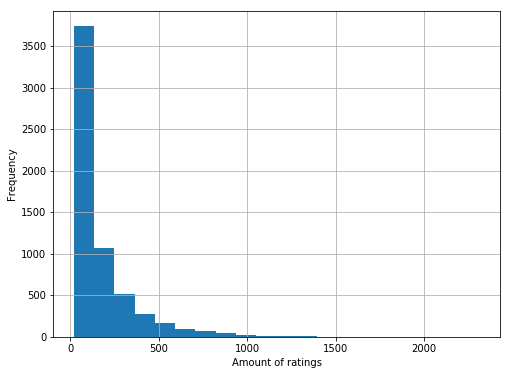

In [8]:
ax = df.groupby('userId').count()['rating'].hist(bins=20, figsize=(8, 6))
ax.set_xlabel('Amount of ratings')
ax.set_ylabel('Frequency')

#### Histogram of ratings values. 
It shows a tendency of the users to rate 3 or higher rather than 1 or 2.

Text(0, 0.5, 'Frequency')

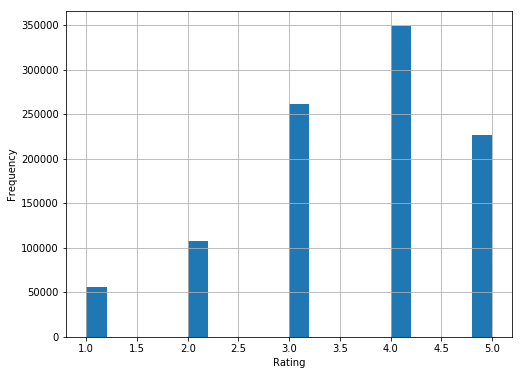

In [9]:
ax = df['rating'].hist(bins=20, figsize=(8, 6))
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')

## Collaborative Filtering
Before this challenge, I hadn't heard about collaborative filtering (CF) because I have never worked with recommendation systems. I enjoyed learning about it and I spent the first day doing some research on the techniques and algorithms used for collaborative filtering and also how it is used in similar applications.

During my research, I discovered an open competition that happened from 2006 to 2009 and was held by Netflix. The goal was to improve the recommendation algorithm that Netflix was using back then, called Cinematch. The dataset provided for the competition was sort of similar to MovieLens, with ratings from 1 to 5 and a high sparsity (88.27%), but less sparse than MovieLens' dataset.

### Matrix factorization

In this competition, matrix factorization techniques showed great results. They work by decomposing the user-movie matrix into the product of two smaller matrices (an important dimensionality reduction) and these two new matrices store latent factors of the users and the movies. The first competitor who used this method for the Netflix prize was Simon Funk (he shared it in a [blog post](https://sifter.org/~simon/journal/20061211.html)), where he proposes an incremental SVD (Singular-value decomposition), i.e. he obtained the two smaller matrices by using stochastic gradient descent (SGD) to minimize the mean squared error between the real rating and the estimated one. The rating of a user $X$ for a movie $Y$ is the dot product between the row $X$ in user latent factor matrix and the column $Y$ of the movie latent factor matrix.

While searching for an implementation of these techniques in Python to save some time, I found the package called Surprise ([https://github.com/NicolasHug/Surprise](https://github.com/NicolasHug/Surprise)). It provides matrix-factorization algorithms, such as SVD, [SVD++](https://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf) (takes into account an implicit feedback) and [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization), and also $k$-nearest neighbors (k-NN) methods, that are based on similarity metrics. One limitation of this package that I found is that the loss function used in the algorithms seems to always be the SGD. From what I found on my research, Alternating Least Squares (ALS) have also been used as an alternative to the SGD in matrix factorization methods.

Due to the high sparsity of the dataset, the matrix factorization techniques may achieve a better performance than the neighborhood techniques. This result is verified with the code bellow, but keeping in mind that the hyperparameters values were the default, so this result may vary. I decided not to include the SVD++ results because it was taking much longer than the regular SVD, more than 30 times longer.

#### Import Surprise classes and methods

In [10]:
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader

from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF

#### Running the SVD technique

In [16]:
# Fix the seed
seed = 0
np.random.seed(seed)
random.seed(seed)

# Instantiate a Reader, setting the rating scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# Reading from the DataFrame, the columns must correspond to user id, movie id
# and ratings (in this order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Using KFold cross validation, where 1 fold is used as a testset and the
# remaining folds are used for training. With 5 folds, 20% of the dataset
# is used for testing.
n_folds = 5
kf = KFold(n_splits=n_folds, random_state=seed)

# Testing multiple algorithms, including matrix factorization
# methods and neighborhood models.
models = [SVD(), NMF(), KNNBasic()]
for model in models:
    # Run 5-fold cross-validation and print results
    cross_validate(model, data, measures=['RMSE', 'MAE'], cv=kf, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8721  0.8702  0.8753  0.8738  0.8761  0.8735  0.0022  
MAE (testset)     0.6845  0.6840  0.6873  0.6863  0.6871  0.6858  0.0013  
Fit time          48.21   51.49   51.64   48.04   43.40   48.55   3.00    
Test time         3.11    2.89    2.53    2.41    2.26    2.64    0.31    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9173  0.9154  0.9182  0.9177  0.9155  0.9168  0.0011  
MAE (testset)     0.7247  0.7239  0.7256  0.7251  0.7227  0.7244  0.0010  
Fit time          45.69   48.60   48.23   45.02   43.08   46.12   2.06    
Test time         2.44    2.60    2.21    2.18    2.16    2.32    0.17    
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (te

### Grid searching hyperparameters
In the previous test with SVD, NMF and k-NN, the SVD achieved the best performance with a mean RMSE of $0.8735$ and a mean MAE of $0.6858$ across the folds. I decided to try a small grid search on the SVD hyperparameters to see how much better it can get. Below I list the values that I tried for each parameter, highlighting the default values in bold:

- `n_epochs` (amount of epochs): <b>20</b>, 30
- `n_factors` (amount of latent factors): 50, <b>100</b>, 200, 300
- `lr_all` (learning rate): 0.002, <b>0.005</b>

In [ ]:
# Fix the seed
seed = 0
np.random.seed(seed)
random.seed(seed)

# Instantiate a Reader, setting the rating scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# Reading from the DataFrame, the columns must correspond to user id, movie id
# and ratings (in this order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Using KFold cross validation, where 1 fold is used as a testset and the
# remaining folds are used for training. With 5 folds, 20% of the dataset
# is used for testing.
n_folds = 5
kf = KFold(n_splits=n_folds, random_state=seed)

param_grid = {'n_epochs': [20, 30], 'n_factors': [50, 100, 200, 300], 'lr_all': [0.002, 0.005]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)

gs.fit(data)

The best set of parameters for the SVD matrix factorization is listed below. The only parameter that is different from the default value is `n_factors`, where 50 latent factors resulted in smaller mean RMSE and mean MAE across the folds when compared to the default value of 100 factors.

- `n_epochs`: 20
- `n_factors`: 50
- `lr_all`: 0.005

The mean RMSE achieved using these parameters is approximately $0.8706$, slightly smaller than when the default parameters were used.

In [26]:
print("Best set of parameters: " + str(gs.best_params['rmse']))
print("Mean RMSE with the optimal parameters: " + str(gs.best_score['rmse']))
print("Mean MAE with the optimal parameters: " + str(gs.best_score['mae']))

Best set of parameters: {'n_epochs': 20, 'n_factors': 50, 'lr_all': 0.005}
Mean RMSE with the optimal parameters: 0.8706240913919906
Mean MAE with the optimal parameters: 0.683606627957602


### Neural network approach using embedding layers
Following the same principles discussed before for matrix factorization, embedding layers can be used to reduce the dimensionality and to extract latent information about the users and the movies. The users and movie ids, that are categorical values, are turned into embedded vectors that can be used as the input of a neural network.

In order to implement the model, I use my two favorite libraries called [scikit-learn](https://scikit-learn.org/), that has some very useful utilities and basic models, and [Keras](https://keras.io/). Keras works as an API for either Theano or Tensorflow backend and it has the implementation of many different Machine Learning techniques, such as a variety of activation functions, weight initializations, regularizers, optimization functions, batch normalization, embedding layers, convolutional layers and so on.

I tried solving the challenge either as a classification and a regression problem, but regression showed to be the best option. The model that I propose consists of two embeddings layers, one for the users and the other for the movies, that are concatenated and fed to a 50 neurons hidden layer. This hidden layer uses ReLU as its activation functions, that avoids vanishing gradients and generates a sparse representation because some neurons may be deactivated. I used the He initialization, that takes in account the size of the previous layer, to improve the weights convergence. I also added a L2 regularizer, that penalizes big weight values, because the network was overfitting very easily. I used batch normalization to make the convergence quicker and more stable. In order to prevent overfitting as well, I added a dropout that can be tuned.

The output layer has a single neuron with a linear activation function. The loss function that I used was the mean squared error (MSE), which makes the gradient larger when the loss function is larger and the gradient gets smaller as the error decreases, leading to a more precise convergence, but it is less robuts to outliers. I used the Adam optimizer to update the weights and bias in the network, that has adaptive learning rate and momentum for each parameter and it is widely used.

Regarding the hyperparameter tuning, I tuned the dropout value, the learning rate and the size of the embedding layer. As I used batch normalization and L2 regularization on the weights, I managed to use a small dropout, 20%. I tweaked the Adam learning rate a bit, but the default value of 0.001 seems to the best one. To choose the embedding layer size, I used a rule of thumb, described in [a post on Google Developers blog](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html), where the amount of features of the embedding layer should be the 4th root of its dictionary size. As the maximum user id is 6040 and the maximum movie id is 3952, I chose to use 8 features on both embedding layers.

\begin{equation}
\sqrt[4]{6040} \approx 8.8 \\
\sqrt[4]{3952} \approx 7.9
\end{equation}

#### Importing Keras and scikit-learn classes and methods

In [13]:
from keras import Model

from keras.layers import Embedding, Flatten, Concatenate
from keras.layers import Input, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import he_normal
from keras.models import load_model

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

Using TensorFlow backend.


#### Defining the model architecture
Model with tunable embedding layer size and dropout.

In [14]:
def EmbeddingMLPModel(max_users, max_movies, n_factors, dropout=0, seed=None):
    
    user_input = Input(shape=[1], name='user')
    movie_input = Input(shape=[1], name='movie')

    user_embedding = Embedding(max_users + 1, n_factors, input_length=1)(user_input)
    movie_embedding = Embedding(max_movies + 1, n_factors, input_length=1)(movie_input)

    user_vec = Flatten()(user_embedding)
    
    movie_vec = Flatten()(movie_embedding)

    y = Concatenate()([user_vec, movie_vec])
    y = Dense(50, activation='relu', 
              kernel_regularizer=l2(0.001), 
              kernel_initializer=he_normal(seed=seed))(y)
    y = BatchNormalization()(y)
    y = Dropout(rate=dropout)(y)
    y = Dense(1, activation='linear')(y)
    
    return Model([user_input, movie_input], y)

#### Training step
Splitting the dataset into train (80%) and test (20%), using the test set to early stop the training, avoidding an overfit. I used another Keras callback to save only the model with the lowest validation loss.

In [ ]:
# Fixed seed
seed = 0
np.random.seed(seed)
random.seed(seed)

# Model parameters
n_factors = 8
dropout = 0.2

# Getting the maximum user id and movie id
n_users = max(df['userId'])
n_movies = max(df['movieId'])

# Separating input and target variables from the DataFrame
X = df[['userId', 'movieId']].values
y = df['rating'].values.reshape(-1, 1)

# Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Configuring early stopping and checkpoint callbacks
callbacks = [EarlyStopping('val_loss', patience=5),
             ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')]

# Creating the model
model = EmbeddingMLPModel(n_users, n_movies, n_factors, dropout, seed)

# Compiling the model
model.compile(loss='mse', optimizer='adam')

# Fitting the model for up to 100 epochs
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, callbacks=callbacks,
                    validation_data=([X_test[:, 0], X_test[:, 1]], y_test), 
                    epochs=100, batch_size=128, verbose=0)

#### Evaluate the RMSE and MAE on the training and test sets using the best saved model

In [16]:
best_model = load_model('best_model.hdf5')

# Train set evaluation
yhat_train = best_model.predict([X_train[:, 0], X_train[:, 1]])
print('Rating RMSE (train): %.4f' % np.sqrt(mean_squared_error (y_train, yhat_train)))
print('Rating MAE (train): %.4f' % mean_absolute_error (y_train, yhat_train))

# Test set evaluation
yhat_test = best_model.predict([X_test[:, 0], X_test[:, 1]])
print('')
print('Rating RMSE (test): %.4f' % np.sqrt(mean_squared_error (y_test, yhat_test)))
print('Rating MAE (test): %.4f' % mean_absolute_error (y_test, yhat_test))

Rating RMSE (train): 0.8096
Rating MAE (train): 0.6345

Rating RMSE (test): 0.8666
Rating MAE (test): 0.6799


#### Checking the loss function during the epochs to detect overfitting

Text(0.5, 1.0, 'Loss function values during the training step')

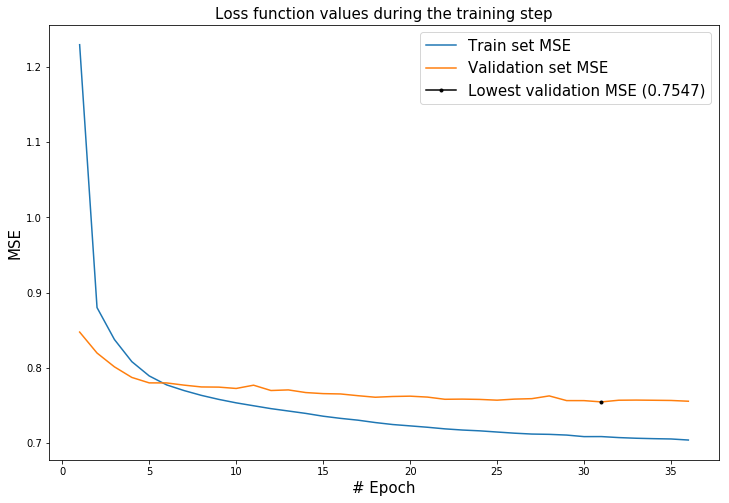

In [34]:
fontsize = 15

min_val_loss = np.min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1

epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs_range, history.history['loss'])
plt.plot(epochs_range, history.history['val_loss'])

plt.plot(min_val_loss_epoch, min_val_loss, marker='o', markersize=3, color="black")

plt.legend(['Train set MSE', 'Validation set MSE', 'Lowest validation MSE (0.7547)'], fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('# Epoch', fontsize=fontsize)
plt.title('Loss function values during the training step', fontsize=fontsize)

### Conclusion

The challenge goal was to propose a neural network model capable of predicting user ratings to a set of movies. A dataset was provided with around a million ratings of 3706 movies rated by 6040 users. The dataset is very sparse and ratings of 3, 4 and 5 are far more common than 1 and 2 ratings. 

First, I showed a known technique based on SVD matrix factorization that got very famouns during the Netflix prize. I achieved a RMSE of 0.8706 and a MAE equal to 0.6836, approximately, after a grid search of some parameters using this method.

Second, I propose my solution to the challenge using two embedding layers connected to a hidden layer, which is connected to the output layer, treating the problem as a regression. I tested solving this as a classification problem with each rating being a target class, but the dataset is very imbalanced, as mentioned before. With some hyperparameters tuning, I managed to achieve, using the test set, a RMSE of 0.8666 and a MAE equal to 0.6799, a better result than the one I obtained using the SVD method.

The neural network method has some downsides, though. Depending on the network complexity, the training process and the hyperparameters tuning can be very costly. In addition to that, if new users or new movies are added, the model must be retrained in order to have an embedded representation of the new inputs.